# Fit Phytoplankton

In [41]:
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, time
import random 

import pandas
import seaborn as sns
import corner

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments

from cnmf.oceanography import iops
from cnmf import zhu_nmf as nmf
from cnmf import io as cnmf_io

import mcmc_ph

In [2]:
%matplotlib ipympl

# Load L23

In [22]:
nmf_fit, N_NMF, iop = 'L23', 4, 'a'
d = cnmf_io.load_nmf(nmf_fit, N_NMF, iop)
M = d['M']
coeff = d['coeff']
wave = d['wave']

## Cut the wavelengths

In [23]:
cut_wave = wave[2:]
a_ph = M[0][2:]

# Generate the profiles

## Chl

In [24]:
chla = pigments.a_chl(cut_wave, ctype='a')
chlb = pigments.a_chl(cut_wave, ctype='b')
chlc = pigments.a_chl(cut_wave, ctype='c12')

## Pigments

In [25]:
reload(pigments)
pig_profiles = []
for ss in range(len(pigments.pig_peak_loc)):
    profile = pigments.gen_pigment(cut_wave, ss)
    pig_profiles.append(profile)

## Concatenate

In [26]:
profiles = np.vstack([chla, chlb, chlc]+pig_profiles)#, axis=0)
profiles.shape

(15, 69)

In [27]:
profiles.max()

1.0

## Check

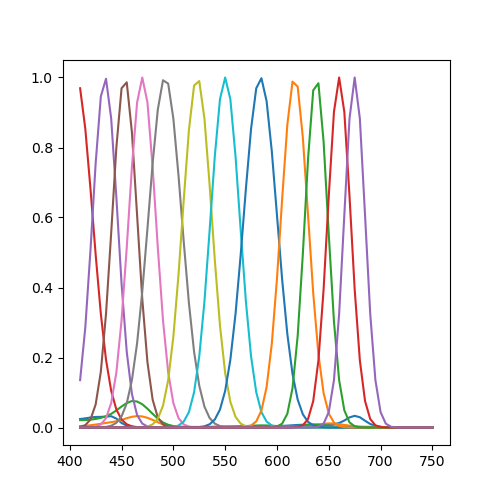

In [47]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
for iprofile in profiles:
    ax.plot(cut_wave, iprofile)
#
plt.show()

# Ready to rock?

## Quick test

In [30]:
reload(mcmc_ph)
param = np.ones(profiles.shape[0])
mcmc_ph.log_prob(param, a_ph, profiles)

-98601673.92608194

## Do it

In [36]:
reload(mcmc_ph)
sampler = mcmc_ph.run_emcee(cut_wave, a_ph, profiles)

Running burn-in
Running full model
All done: Wrote None


## Plot

In [44]:
labels = ['Chla', 'Chlb', 'Chlc'] + [f'pig{item}' for item in range(len(pig_profiles))]

### Chains

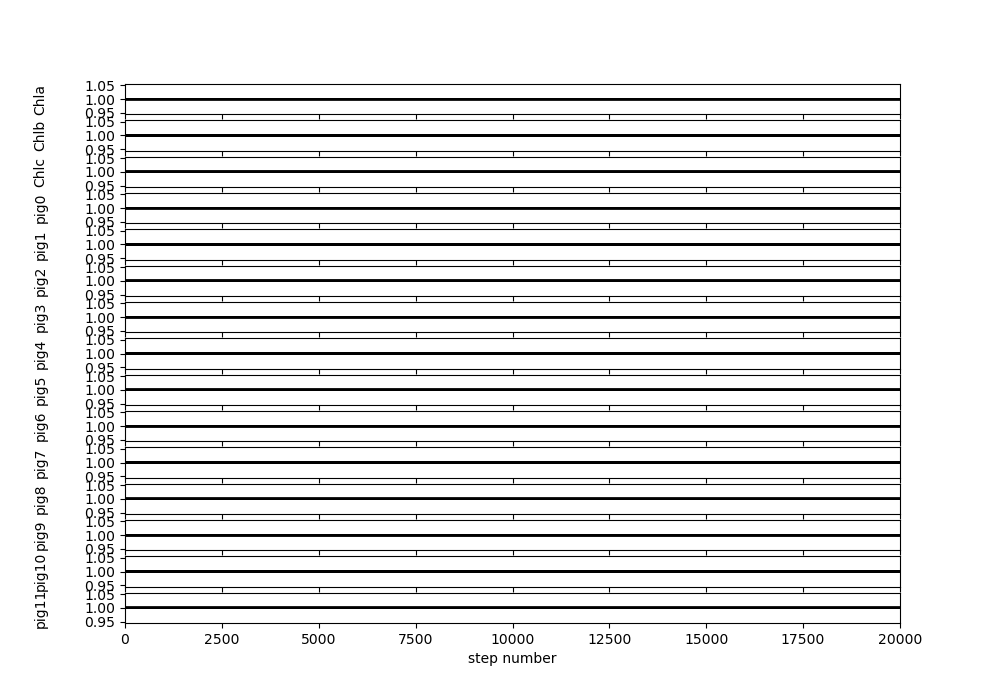

In [46]:
ndim = 15
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
#labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [37]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [43]:
flat_samples.shape

(42432, 15)

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14 have no dynamic range. Please provide a `range` argument.

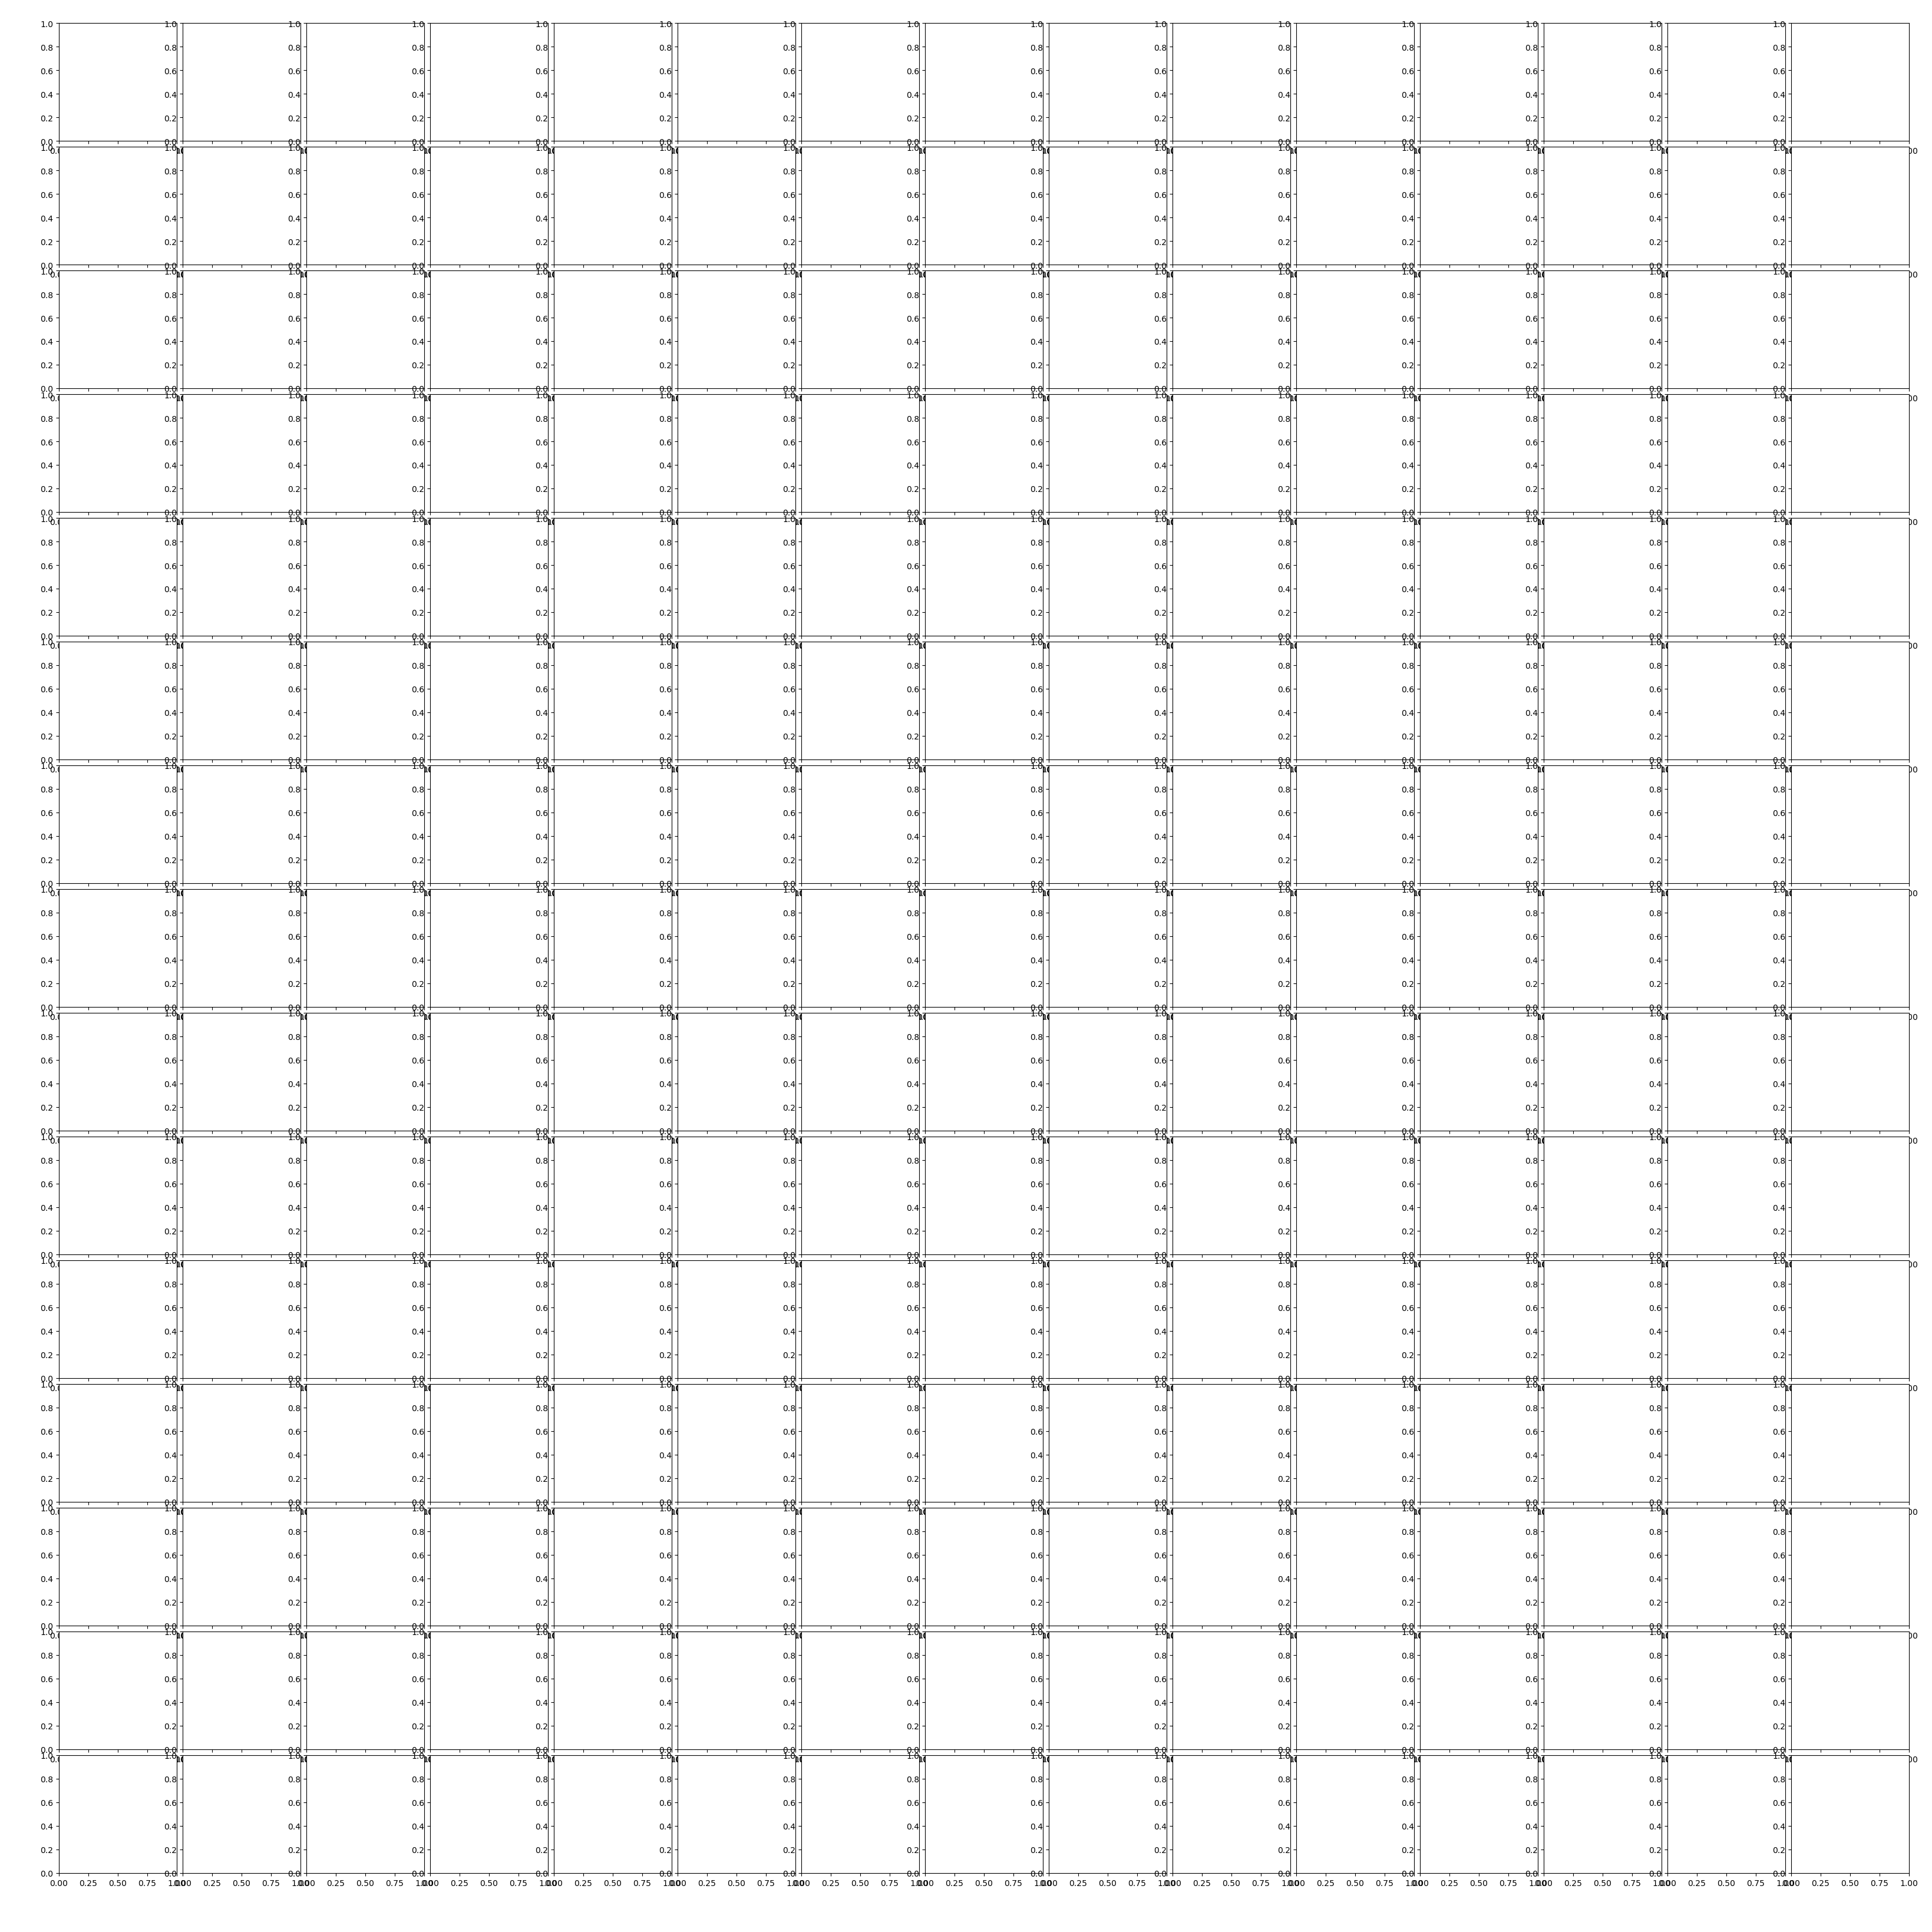

In [42]:
fig = corner.corner(
    flat_samples, labels=labels,#, truths=[m_true, b_true, np.log(f_true)]
)

In [ ]:
fig = corner.corner(
    coeff[:,:4], labels=['a0', 'a1', 'a2', 'a3'],
        label_kwargs={'fontsize':17},
        show_titles=True,
        title_kwargs={"fontsize": 12},
        )
plt.tight_layout()
plt.show()